## Time Series Classification using Gaussian processes with Signature Covariances
#### _Using SVGP with SignatureRBF kernel over sequences and inducing tensors as inducing point locations_
_Dataset: LIngua BRAsileira de Sinais (LIBRAS)_
***

In [52]:
# imports
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import pandas as pd

import sys
sys.path.append('..') # add to path parent dir of gpsig

# computations
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import gpflow as gp
import gpsig

# preprocessing, model evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# data loading
import requests, zipfile, io
from sktime.utils.load_data import load_from_arff_to_dataframe

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
config.gpu_options.polling_inactive_delay_msecs = 10
session = tf.compat.v1.Session(config=config)

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.7  # GPU 메모리의 70%만 사용
session = tf.Session(config=config)

***
### Load dataset
Load a multivariate time series dataset (LIBRAS) from timeseriesclassification.com (https://arxiv.org/abs/1811.00075).

__LIBRAS__ is an acronym for the official Brazilian sign language. The dataset consists of 15 classes with 24 instances each. Each example corresponds to a 2-dimensional curve followed by the hand while performing the given sign with 45 time-observations.

In [53]:
df = pd.read_csv('C:/Users/Admin/Desktop/gpsig/R/DF_train.csv')

X_train = pd.DataFrame(columns=['dim_0'])

for i in range(160):
    start_idx = i * 100
    end_idx = (i + 1) * 100
    
    dim_0_series = pd.Series(df.iloc[start_idx:end_idx, 1].values)
    
    X_train = X_train.append({
        'dim_0': dim_0_series
    }, ignore_index=True)

X_train

,dim_0
0,0 0.120505 1 0.123792 2 0.122382 3...
1,0 0.115950 1 0.135276 2 0.127521 3...
2,0 0.117051 1 0.118803 2 0.124562 3...
3,0 0.127460 1 0.131325 2 0.126139 3...
4,0 0.124240 1 0.128961 2 0.117622 3...
...,...
155,0 0.124412 1 0.135498 2 0.129813 3...
156,0 0.128617 1 0.128348 2 0.129695 3...
157,0 0.123281 1 0.129522 2 0.121080 3...
158,0 0.116270 1 0.124654 2 0.132561 3...


In [54]:
df = pd.read_csv('C:/Users/Admin/Desktop/gpsig/R/DF_test.csv')

X_test = pd.DataFrame(columns=['dim_0'])

for i in range(160):
    start_idx = i * 100
    end_idx = (i + 1) * 100
    
    dim_0_series = pd.Series(df.iloc[start_idx:end_idx, 1].values)
    
    X_test = X_test.append({
        'dim_0': dim_0_series
    }, ignore_index=True)

X_test

,dim_0
0,0 0.115433 1 0.125018 2 0.116764 3...
1,0 0.132182 1 0.117754 2 0.122454 3...
2,0 0.115800 1 0.117458 2 0.123582 3...
3,0 0.128882 1 0.122286 2 0.129958 3...
4,0 0.116525 1 0.129728 2 0.119561 3...
...,...
155,0 0.122519 1 0.120210 2 0.129872 3...
156,0 0.119362 1 0.126040 2 0.120119 3...
157,0 0.119522 1 0.121930 2 0.133492 3...
158,0 0.121971 1 0.127297 2 0.129160 3...


In [55]:
# 1: co2, 2: gas
y_train = np.array([1]*20 + [2]*20 + [3]*20 + [4]*20 + [5]*20 + [6]*20 + [7]*20 + [8]*20)
y_test = y_train
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8])

***
### Format and preprocess data

We first take care of formatting the outputs $\mathbf{Y} = (\mathbf{y}_i)_{i=1,\dots,n_{\mathbf{x}}}$. We are going to use the GPflow MultiClass likelihood as observation model as the problem class is multi-class classification. It expects that class labels are assigned from $\{0, 1, \dots, n_{c}-1\}$ with $n_c$ the number of classes, hence we simply relabel all examples.

In [56]:
labels_dict = {c : i for i, c in enumerate(np.unique(y_train))}
y_train = np.asarray([labels_dict[c] for c in y_train])
y_test = np.asarray([labels_dict[c] for c in y_test])
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7])

To format the inputs $\mathbf{X} = (\mathbf{x}_i)_{i=1,\dots,n_{\mathbf{X}}} \subset \mathbb{R}^d_{seq}$, we convert the data to a list of sequences, with each sequence $\mathbf{x} \in \mathbf{X}$ given as an $(l_{\mathbf{x}}, d)$ numpy array.

In [57]:
X_train = [np.stack(x, axis=1) for x in X_train.values]
X_test = [np.stack(x, axis=1) for x in X_test.values]


# 첫번째 데이터에 CO2.csv BD2,  sensor4에 해당하는 값이 들어있으므로 전처리가 정상적으로 이루어졌다.

Now as preprocessing, we first add a monotonically increasing coordinate with unit steps between time-observations, that we call "time", and its role is to allow signatures to separate sequences, that are not equal, but can be warped into one another. Hence, denoting time-augmentation as $\hat{\cdot}: \mathbb{R}^d_{seq} \rightarrow \mathbb{R}^{d+1}_{seq}$ defined for $\mathbf{x} = (x_i)_{i=1,\dots,l_\mathbf{x}}$ as $\hat{\mathbf{x}} := (t_i, x_i)_{i=1,\dots,l_{\mathbf{x}}}$, where $t_i := i / l_{\mathbf{x}}$.

In [58]:
# implemented in gpsig as a convenience function
X_train = gpsig.preprocessing.add_time_to_list(X_train)
X_test = gpsig.preprocessing.add_time_to_list(X_test)

As we would like to have a validation set that we monitor while optimizing the hyperparameters of the model, we split the training data 80-20 in a stratified manner.

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train)

Continuing with the preprocessing, we jointly normalize using the training set all state-space dimensions (in this case, the time coordinate and the two coordinates corresponding to hand-movements) to zero mean and unit variance.

In [60]:
scaler = StandardScaler()
scaler.fit(np.concatenate(X_train, axis=0))

X_train = [scaler.transform(x) for x in X_train]
X_val = [scaler.transform(x) for x in X_val]
X_test = [scaler.transform(x) for x in X_test]

Finally, as the dataformat of the inputs should be a numpy array of size $(n_{\mathbf{X}}, \max_{\mathbf{x} \in \mathbf{X}} l_{\mathbf{x}}, d)$, we tabulate all sequences to equal length (in case they weren't already), by repeating for each $\mathbf{x} \in \mathbf{X}$ the last observation $\max_{\tilde{\mathbf{x}} \in \mathbf{X}} l_{\tilde{\mathbf{x}}} - l_{\mathbf{x}}$ times.

In [61]:
# using another convenience function from gpsig
X_train = gpsig.preprocessing.tabulate_list_of_sequences(X_train)
X_val = gpsig.preprocessing.tabulate_list_of_sequences(X_val)
X_test = gpsig.preprocessing.tabulate_list_of_sequences(X_test)

100%|█████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 38415.97it/s]


To check that everything we did makes sense, we investigate the sizes of the data arrays and plot some examples from the inputs and a histogram from the outputs.

X_train shape: (128, 100, 2)
y_train shape: (128,)
X_val shape: (32, 100, 2)
y_val shape: (32,)
X_test shape: (160, 100, 2)
y_test shape: (160,)


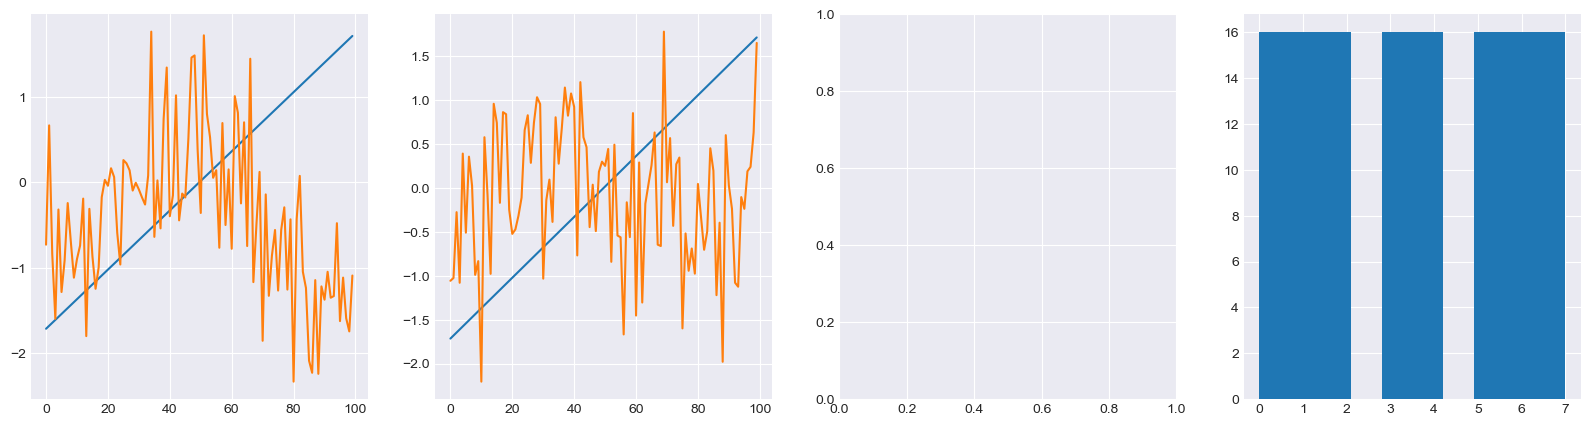

In [62]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].plot(X_train[0])
axes[1].plot(X_train[20])
axes[3].hist(y_train)

plt.show()

***
### Setup SVGP model

In [63]:
num_train, len_examples, num_features = X_train.shape
num_val = X_val.shape[0]
num_test = X_test.shape[0]
num_classes = np.unique(y_train).size

We are going to use $M=5$ levels in the signature kernel, i.e. the truncated signature kernel of depth $M=5$. The data will be summarized using $n_{\mathbf Z} = 200$ inducing tensors in the variational posterior. For simpliciy, we use $p=0$ lags in the signature kernel.

In [64]:
num_levels = 5
num_inducing = 200
num_lags = 0

To initialize the inducing tensors, we use a function from gpsig that samples random sparse tensors from the input sequences, and initialize the lengthscales by $l_i^{(0)} := \sqrt{\mathbb{E}\vert x_i - \tilde{x}_i\vert^2\cdot d}$ for $i \in \{1, 2, \dots, d\}$ using $n = 1000$ randomly selected observation samples from the data.

In [65]:
Z_init = gpsig.utils.suggest_initial_inducing_tensors(X_train, num_levels, num_inducing, labels=y_train, increments=True, num_lags=num_lags)
l_init = gpsig.utils.suggest_initial_lengthscales(X_train, num_samples=1000)

In [66]:
y_train

array([6, 1, 1, 7, 1, 0, 1, 3, 4, 5, 2, 7, 4, 4, 1, 1, 7, 0, 5, 6, 3, 5,
       0, 2, 0, 7, 0, 6, 5, 7, 7, 5, 5, 6, 2, 2, 5, 3, 0, 6, 4, 2, 6, 0,
       0, 7, 6, 6, 2, 3, 1, 3, 5, 7, 3, 5, 3, 4, 2, 6, 4, 2, 3, 6, 4, 3,
       0, 5, 7, 7, 3, 7, 7, 5, 2, 6, 4, 7, 3, 0, 1, 3, 1, 0, 4, 4, 0, 3,
       5, 3, 0, 6, 5, 6, 4, 2, 4, 7, 5, 4, 0, 3, 6, 2, 4, 5, 2, 0, 5, 3,
       1, 1, 1, 2, 7, 2, 4, 1, 1, 6, 7, 1, 6, 2, 4, 0, 2, 1])

Since GPflow kernels usually expect as inputs numpy arrays in a 2d axis format, we flatten out the last two dimensions of the input arrays (which are then expanded again inside the kernel calculations).

In [67]:
input_dim = len_examples * num_features
X_train = X_train.reshape([-1, input_dim])
X_val = X_val.reshape([-1, input_dim]) if X_val is not None else None
X_test = X_test.reshape([-1, input_dim])

Next instantiate the different parts of the model.
***
#### _InducingTensors_
Arguments:
- Z - a numpy array of size $(M(M+1)/2, n_{\mathbf Z}, d)$ if increments is False, $(M(M+1)/2, n_{\mathbf Z}, 2, d)$ if increments is True (see kwargs)
- num_levels - the same number of levels as in the signature kernel

Kwargs:
- increments - if this is set to true, then a different size Z is expected and the inducing tensors are represented for $\mathbf{z} \in \mathbf{Z}$ as $\mathbf{z} = (z_m)_{m=1,\dots,M}$ with
\begin{align}
    z_m = \left(\kappa(x_{m, 1, 2}, \cdot) - \kappa(x_{m, 1, 1}, \cdot)\right) \otimes \left(\kappa(x_{m, 2, 2}, \cdot) - \kappa(x_{m, 2, 1}, \cdot)\right) \otimes \dots \otimes \left(\kappa(x_{m, m, 2}, \cdot) - \kappa(x_{m, m, 1}, \cdot)\right),
\end{align}
while for increments==False they are simply
\begin{align}
    z_m = \kappa(x_{m, 1}, \cdot) \otimes \kappa(x_{m, 2}, \cdot) \otimes \dots \otimes \kappa(x_{m, m}, \cdot),
\end{align}
where $\kappa(\cdot, \cdot)$ is a positive definite kernel over $\mathbb{R}^d$. We find that using the increments version greatly improves their flexibility.
- learn_weights - experimental, if False, then everything as before, if True, then an additional linear combination layer is inserted with the inducing tensors $\mathbf{z}^\prime \in \mathbf{Z}^\prime$ defined as $\mathbf{z}^\prime = (z_m^\prime)_{m=0,\dots,M}$ and
\begin{align}
    \mathbf{z}_m^\prime = \sum_{i=1}^{n_{\mathbf Z}} \alpha_i \mathbf{z}_m \hspace{10pt}\text{for}\hspace{10pt} \mathbf{z}_m \in \mathbf{Z}_m,
\end{align}
where $\mathbf{Z}_m$ is as before.

Suggested setting is to use increments=True and learn_weights=False.

In [68]:
feat = gpsig.inducing_variables.InducingTensors(Z_init, num_levels=num_levels, increments=True)

***
#### _SignatureRBF_
The signature kernel for sequences using as state-space embedding the RBF kernel  $\kappa: \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}^d$, i.e. $\kappa(x, x^\prime) = \exp\left(-\frac{1}{2} (x - x^\prime)^\top \Sigma^{-1} (x - x^\prime) \right)$ for $x, x^\prime \in \mathbb{R}^d$

Concretely, for two sequences $\mathbf{x}, \mathbf{x}^\prime \in \mathbb{R}^d$, the sequence kernel derived from signatures can be written as

\begin{align}
    k(\mathbf{x}, \mathbf{x}^\prime) = \sum_{m=0}^M \sum_{\substack{1 \leq i_1 \leq \dots \leq i_m < l_{\mathbf x}} \\ 1 \leq j_1 \leq \dots \leq j_m < l_{\mathbf{x}^\prime}} \sigma_m^2 \cdot c(i_1, \dots, i_m) \cdot c(j_1, \dots j_m) \cdot \prod_{l=1}^m \left(\kappa(x_{i_l+1}, x^\prime_{j_l+1}) + \kappa(x_{i_l}, x^\prime_{j_l}) - \kappa(x_{i_l}, x^\prime_{j_l+1}) - \kappa(x_{i_l+1}, x^\prime_{j_l}) \right),
\end{align}
for some explicitly known constants $c: \mathbb{N}^m \rightarrow \mathbb{R}$ for each $m \in \{1, \dots, M\}$.

Arguments:
- input_dim - the total size of an input sample to the kernel, i.e. $l_{\mathbf X} \cdot d$
- num_features - the state-space dimension of the input sequences, i.e $d$ for sequences in $\mathbb{R}^d_{seq}$
- num_levels - the degree of cut-off for the truncated signatures
 
Kwargs:
- num_lags - (default 0) the number of lags ($p$) added to each sequence, i.e. $\hat{\mathbf{x}} = (t_i, x_{t_i}, x_{t_i - s_1}, \dots, x_{t_i - s_{p}})$ for $\mathbf{x} = (t_i, x_i)$
- order - (default 1) specifies the approximation order ($D$) to the signature kernel (see http://jmlr.org/papers/v20/16-314.html), denoted by $1 \leq D \leq M$. Relates to the constants $c(i_1, i_2, \dots, i_m)$ in the above formula. An illustrative example is to consider a sequence with two elements $\mathbf{x} = (x_1, x_2)$. Then, for $D=1$
\begin{align}
    \mathbf{S}^{(1)}(\mathbf{x}) = \left(1, (x_2 - x_1), 0, 0, \dots\right),
\end{align}
and for $D=M$
\begin{align}
    \mathbf{S}^{(M)}(\mathbf{x}) = \left(1, (x_2 - x_1), (x_2 - x_1)^{\otimes 2}/2!, (x_2 - x_1)^{\otimes 3}/3!, \dots, (x_2 - x_1)^{\otimes M}/M!, 0, 0, \dots \right),
\end{align}
while for $D \in \{1, 2, \dots, M\}$ in general
\begin{align}
    \mathbf{S}^{(D)}(\mathbf{x}) = \left(1, (x_2 - x_1), (x_2 - x_1)^{\otimes 2}/2!, (x_2 - x_1)^{\otimes 3}/3!, \dots (x_2 - x_1)^{\otimes D}/D!, 0, 0, \dots \right).
\end{align}

- normalization - if False, no normalization, if True each level of the signature kernel is normalized as
\begin{align}
\tilde{k}(\mathbf x, \mathbf{x}^\prime) = \sum_{m=0}^M \sigma_m^2 \frac{k_m(\mathbf{x}, \mathbf{x}^\prime)}{\sqrt{k_m(\mathbf{x}, \mathbf{x})k_m(\mathbf{x}^\prime, \mathbf{x}^\prime)}},
\end{align}
that we find in practice to help with training more efficiently

- variances - initialization of $(\sigma_0, \sigma_1, \dots, \sigma_M) \in \mathbb{R}_+^{M+1}$       
- lengthscales: - initialization of the lengthscales $(l_1, l_2, \dots, l_{d})$ of the base kernel

- difference - if True, everything as above, if False, the cumulative sequence is used (i.e. $\tilde{\mathbf{x}} = \left( \sum_{j=1}^i x_i\right)_{i=1,\dots,l_{\mathbf x}})$

- active_dims - if specified, should contain a list of the dimensions in the input that should be sliced out and fed to the kernel. if not specified, defaults to range(input_dim)

Low-rank options:
 - low_rank - boolean indicating whether to use low-rank kernel
 - num_components - number of components used in Nystrom approximation
 - rank_bound - max rank of low-rank factor in signature algs, if None, defaults to num_components.
 - sparsity - controls the sparsity of the random projection matrix used in the low-rank algorithm. Possible values are:
     - 'sqrt' - approximately $O(n \cdot \sqrt{n})$ non-zero entries per row;
     - 'log' - approximately $O(n \cdot \log(n))$ non-zero entries per row;
     - 'lin' - approximately $O(n)$ non-zero entries per row;

In [69]:
k = gpsig.kernels.SignatureRBF(input_dim, num_features, num_levels, lengthscales=l_init)

***
The likelihood and the SVGP model use the GPflow syntax, see https://gpflow.readthedocs.io/en/master/. The SVGP from gpsig uses the same syntax as the GPflow SVGP, except that it expects that _feat_ is either an _InducingTensors_ or _InducingSequences_ object derived from the _SignatureInducing_ base class.

In [70]:
if num_classes == 2:
    lik = gp.likelihoods.Bernoulli()
    num_latent = 1
else:
    lik = gp.likelihoods.MultiClass(num_classes)
    num_latent = num_classes

m = gpsig.models.SVGP(X_train, y_train[:, None], kern=k, feat=feat, likelihood=lik, num_latent=num_latent, minibatch_size=50)

***
### Train model using stochastic variational inference

Setup the metrics for training, for monitoring we look at the validation nlpp and the validation accuracy (for early stopping the nlpp is taken into account).

In [71]:
acc = lambda m, X, y: accuracy_score(y, np.argmax(m.predict_y(X)[0], axis=1))
nlpp = lambda m, X, y: -np.mean(m.predict_density(X, y[:, None]))

val_acc = lambda m: acc(m, X_val, y_val)
val_nlpp = lambda m: nlpp(m, X_val, y_val)

test_acc = lambda m: acc(m, X_test, y_test)
test_nlpp = lambda m: nlpp(m, X_test, y_test)

opt = gpsig.training.NadamOptimizer # use Nadam optimizer i.e. Adam with Nesterov momentum

***
First, as usual, fix the kernel hyperparameters and train for a fixed number of iterations to tighten the ELBO bound.

In [72]:
# train model with kernel hyperparameters fixed
m.kern.set_trainable(False)
hist = gpsig.training.optimize(m, opt(1e-3), max_iter=3000, print_freq=100, save_freq=100, val_scorer=[val_acc, val_nlpp])
# org: max_iter=5000

-------------------------
  Starting optimization  
-------------------------
Iteration 100	|	Time: 25.25	|	ELBO: -769.49	|	Val. 0: 0.9062	|	Val. 1: 1.0420
Iteration 200	|	Time: 52.68	|	ELBO: -500.84	|	Val. 0: 0.8438	|	Val. 1: 0.5300
Iteration 300	|	Time: 77.05	|	ELBO: -332.27	|	Val. 0: 0.9062	|	Val. 1: 0.2888
Iteration 400	|	Time: 101.42	|	ELBO: -246.15	|	Val. 0: 0.9688	|	Val. 1: 0.1836
Iteration 500	|	Time: 125.78	|	ELBO: -259.28	|	Val. 0: 0.9375	|	Val. 1: 0.1508
Iteration 600	|	Time: 150.16	|	ELBO: -229.92	|	Val. 0: 0.9375	|	Val. 1: 0.1366
Iteration 700	|	Time: 174.53	|	ELBO: -216.06	|	Val. 0: 0.9375	|	Val. 1: 0.1178
Iteration 800	|	Time: 198.90	|	ELBO: -201.51	|	Val. 0: 0.9375	|	Val. 1: 0.1167
Iteration 900	|	Time: 223.27	|	ELBO: -212.16	|	Val. 0: 0.9375	|	Val. 1: 0.1125
Iteration 1000	|	Time: 247.65	|	ELBO: -197.32	|	Val. 0: 0.9375	|	Val. 1: 0.1121
Iteration 1100	|	Time: 272.03	|	ELBO: -194.52	|	Val. 0: 0.9375	|	Val. 1: 0.1156
Iteration 1200	|	Time: 296.42	|	ELBO: -191.57	|	Val. 0

***
Second, unfix the kernel hyperparameters and train with early stopping with a patience of 5000 iterations.

In [73]:
# unfix kernel hyperparameters and train with early stopping with 5000 iterations patience
m.kern.set_trainable(True)
hist = gpsig.training.optimize(m, opt(1e-2), max_iter=30000, print_freq=100, save_freq=100, history=hist,
                               val_scorer=[val_acc, val_nlpp], save_best_params=True, lower_is_better=True, patience=5000)
m.assign(hist['best']['params'])
# org: max_iter=50000

---------------------------
  Continuing optimization  
---------------------------
Iteration 3100	|	Time: 767.75	|	ELBO: -167.41	|	Val. 0: 0.9375	|	Val. 1: 0.1162
Iteration 3200	|	Time: 796.81	|	ELBO: -156.99	|	Val. 0: 0.9375	|	Val. 1: 0.1344
Iteration 3300	|	Time: 825.16	|	ELBO: -161.36	|	Val. 0: 0.9375	|	Val. 1: 0.1016
Iteration 3400	|	Time: 853.43	|	ELBO: -147.31	|	Val. 0: 0.9375	|	Val. 1: 0.0961
Iteration 3500	|	Time: 881.58	|	ELBO: -142.41	|	Val. 0: 0.9375	|	Val. 1: 0.1139
Iteration 3600	|	Time: 909.90	|	ELBO: -143.78	|	Val. 0: 0.9375	|	Val. 1: 0.1347
Iteration 3700	|	Time: 938.13	|	ELBO: -139.43	|	Val. 0: 0.9375	|	Val. 1: 0.1171
Iteration 3800	|	Time: 966.30	|	ELBO: -134.37	|	Val. 0: 0.9375	|	Val. 1: 0.1155
Iteration 3900	|	Time: 994.59	|	ELBO: -121.54	|	Val. 0: 0.9375	|	Val. 1: 0.1000
Iteration 4000	|	Time: 1023.37	|	ELBO: -131.33	|	Val. 0: 0.9375	|	Val. 1: 0.0995
Iteration 4100	|	Time: 1051.87	|	ELBO: -120.47	|	Val. 0: 0.9375	|	Val. 1: 0.1180
Iteration 4200	|	Time: 1080.34	|	E

***
Third, fix the kernel again and re-merge the validation set into the training data. Train for a fixed number of iterations to assimilate the remaining information into the variational approximation.

In [74]:
X_train, y_train = np.concatenate((X_train, X_val), axis=0), np.concatenate((y_train, y_val), axis=0)
num_train = X_train.shape[0]
m.X, m.Y = X_train, y_train
m.num_data = num_train

m.kern.set_trainable(False)
hist = gpsig.training.optimize(m, opt(1e-3), max_iter=2500, print_freq=100, save_freq=100, history=hist)

# max_iter=5000

---------------------------
  Continuing optimization  
---------------------------
Iteration 8600	|	Time: 2325.20	|	ELBO: -149.17
Iteration 8700	|	Time: 2349.52	|	ELBO: -147.67
Iteration 8800	|	Time: 2373.81	|	ELBO: -145.14
Iteration 8900	|	Time: 2398.11	|	ELBO: -145.23
Iteration 9000	|	Time: 2422.42	|	ELBO: -144.82
Iteration 9100	|	Time: 2446.70	|	ELBO: -132.66
Iteration 9200	|	Time: 2470.99	|	ELBO: -140.01
Iteration 9300	|	Time: 2495.28	|	ELBO: -136.39
Iteration 9400	|	Time: 2519.57	|	ELBO: -126.79
Iteration 9500	|	Time: 2543.87	|	ELBO: -141.89
Iteration 9600	|	Time: 2568.16	|	ELBO: -137.36
Iteration 9700	|	Time: 2592.43	|	ELBO: -142.19
Iteration 9800	|	Time: 2616.74	|	ELBO: -145.66
Iteration 9900	|	Time: 2641.02	|	ELBO: -140.81
Iteration 10000	|	Time: 2665.34	|	ELBO: -148.11
Iteration 10100	|	Time: 2689.64	|	ELBO: -142.12
Iteration 10200	|	Time: 2713.93	|	ELBO: -142.84
Iteration 10300	|	Time: 2738.21	|	ELBO: -145.15
Iteration 10400	|	Time: 2762.51	|	ELBO: -142.20
Iteration 10500	|	

***
### Evaluate model performance

In [75]:
print('Test nlpp.: {:.03f}'.format(test_nlpp(m)))
print('Test acc.: {:.03f}'.format(test_acc(m)))
print('Test classification report:')
print(classification_report(y_test, np.argmax(m.predict_y(X_test)[0], axis=1)))

Test nlpp.: 0.117
Test acc.: 0.950
Test classification report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.95      0.95      0.95        20
           2       1.00      1.00      1.00        20
           3       1.00      0.95      0.97        20
           4       0.86      0.90      0.88        20
           5       0.86      0.95      0.90        20
           6       1.00      0.85      0.92        20
           7       1.00      1.00      1.00        20

    accuracy                           0.95       160
   macro avg       0.95      0.95      0.95       160
weighted avg       0.95      0.95      0.95       160



In [76]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/Z,Parameter,None,(none),True,"(15, 200, 2, 2)",True,"[[[[1.82050991 0.4059925 ], [0.92979239 0.7399..."
SVGP/kern/lengthscales,Parameter,None,+ve,False,"(2,)",True,"[2.378858496095001, 2.234998861709783]"
SVGP/kern/sigma,Parameter,None,+ve,False,(),True,3.362115905448664
SVGP/kern/variances,Parameter,None,+ve,False,"(6,)",True,"[0.5490425897162957, 0.4370583777480571, 1.112..."
SVGP/likelihood/invlink/epsilon,Parameter,"Beta(0.2,5.0)","[0.0, 1.0]",False,(),True,0.0009999999999999996
SVGP/q_mu,Parameter,None,(none),True,"(200, 8)",True,"[[-0.0302715043000433, 0.1288306951798082, 0.0..."
SVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(8, 200, 200)",True,"[[[0.9110771275110183, 0.0, 0.0, 0.0, 0.0, 0.0..."


The variances of each level:


<BarContainer object of 6 artists>

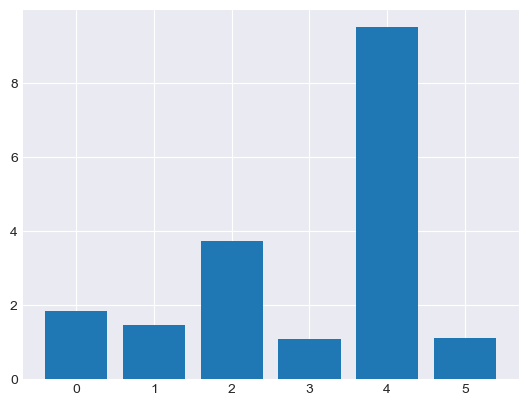

In [77]:
print('The variances of each level:')
plt.bar(range(num_levels+1), m.kern.sigma.value * m.kern.variances.value)

The lengthsacles of each coordinate:


<BarContainer object of 2 artists>

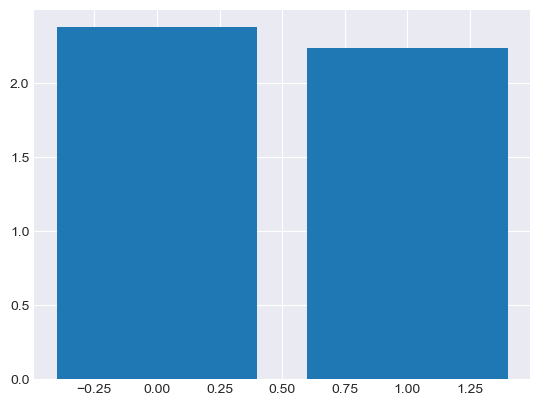

In [78]:
print('The lengthsacles of each coordinate:')
plt.bar(range(num_features), m.kern.lengthscales.value)

### Inspect training curve

In [79]:
time = [y['time'] for x, y in hist.items() if str(x).isnumeric()]
elbo = [y['elbo'] for x, y in hist.items() if str(x).isnumeric()]
val_acc = [y['val'][0] for x, y in hist.items() if str(x).isnumeric() and 'val' in y]
val_nlpp = [y['val'][1] for x, y in hist.items() if str(x).isnumeric() and 'val' in y]

Text(0.5, 1.0, 'Validation nlpp. over time')

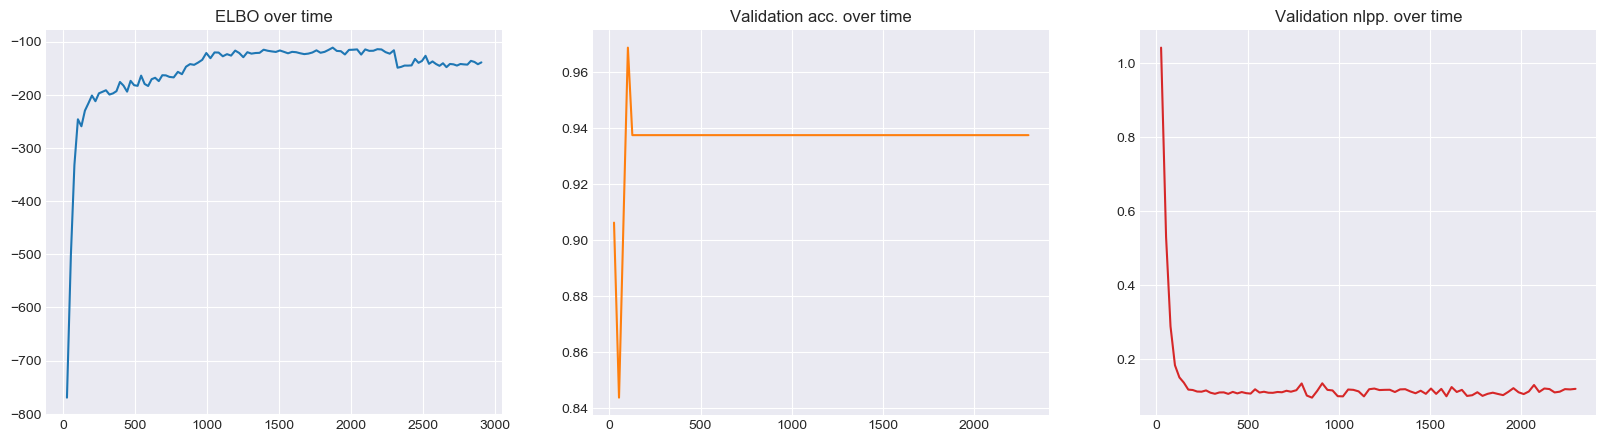

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(time, elbo)
axes[0].set_title('ELBO over time')
axes[1].plot(time[:len(val_nlpp)], val_acc, 'tab:orange')
axes[1].set_title('Validation acc. over time')
axes[2].plot(time[:len(val_nlpp)], val_nlpp, 'tab:red')
axes[2].set_title('Validation nlpp. over time')